# ThoroughBet Simulation


## Load necessary modules

In [68]:
import numpy as np

from thbmodel.utils import timestamp, YEAR, MONTH,settings
from thbmodel.utils.arrayview import ArrayView, TimeseriesView

from thbmodel.prediction.models.fit_model import TSModel
from thbmodel.prediction.models.model_parameters import ModelParameters
from thbmodel.prediction.models.factor_management import FactorList
from thbmodel.prediction.models.preprocessing import load_slices

from thbmodel.prediction.models.prediction import factornames_trimmed
from thbmodel.prediction.models.parameters import factor_build_end

## Load data

In [2]:
av = ArrayView.from_file(settings.paths.join('racing_data_azd.av.bcolz'))
tsav = load_slices()

## Preprocessing

In [124]:
build_end =float(timestamp('2016-01-01'))
oos_start =float(timestamp('2017-04-01'))
pars = ModelParameters(av, build_end =build_end, oos_start =oos_start, depth=1, lmbd=10, verbose=False)

In [113]:
#pars.is1, pars.is2, pars.oos = pars.get_model_mask(pars.valid, t0 =build_ends, t1 = build_ends + size,   t2= pars.oos_start)

In [125]:
fl = FactorList.from_av(av, factornames_trimmed)

In [126]:
fl.preprocess(pars)
factors = fl.asmatrix()

In [127]:
print 'is1_start  ',(timestamp(av.start_time[pars.is1][0]))
print 'is1_end  ',(timestamp(av.start_time[pars.is1][-1]))
print 'oos_start  ',(timestamp(av.start_time[pars.oos][0]))
print 'oos_end  ',(timestamp(av.start_time[pars.oos][-1]))

is1_start   2016-01-01 12:20:00.000000
is1_end   2017-03-31 16:00:00.000000
oos_start   2017-04-01 12:30:00.000000
oos_end   2017-08-20 15:00:00.000000


### Fit conditional logit model

In [100]:
tsmod = TSModel(factors, tsav, pars)

In [101]:
tsmod.fit_slices()
print 'LL................'
print tsmod.stats2.ll

LL................
[[-1841.16182972 -1960.6539293  -1960.6539293 ]
 [-1844.86130674 -1959.09698053 -1959.09698053]
 [-1848.26303751 -1958.50214244 -1958.50214244]
 [-1850.00801382 -1956.65444002 -1956.65444002]
 [-1860.49858527 -1951.57092557 -1951.57092557]
 [-1869.62229867 -1949.93409626 -1949.93409626]
 [-1894.48240492 -1948.51826749 -1948.51826749]
 [-1903.44091623 -1946.15696686 -1946.15696686]
 [-1906.14729081 -1947.78232804 -1947.78232804]
 [-1908.25121082 -1946.75381435 -1946.75381435]
 [           nan            nan            nan]]


### Fit some models with different train set 

In [117]:
is1 = pars.is1.copy()
is2 = pars.is2.copy()
oos = pars.oos.copy()

In [128]:
int((av.start_time[pars.is1][-1] - av.start_time[pars.is1][0])/MONTH)

15

In [147]:
time_model = {}
step = MONTH
N_model = int((av.start_time[pars.is1][-1] - av.start_time[pars.is1][0])/step)
size = MONTH 

train_ll = np.zeros((N_model))
test_ll = np.zeros((N_model))
train_ll_mean = np.zeros((N_model))
test_ll_mean = np.zeros((N_model))

for n in range(N_model):
    
    if n == 0:
        build_ends = build_end 
    else:
        build_ends = build_ends + step
    
    pars.is1, pars.is2, pars.oos = pars.get_model_mask(pars.valid, t0 =build_ends, 
                                                       t1 = build_ends + size,
                                                       t2= pars.oos_start)
    print 'is1_start  ',(timestamp(av.start_time[pars.is1][0]))
    print 'is1_end  ',(timestamp(av.start_time[pars.is1][-1]))
    print 'oos_start  ',(timestamp(av.start_time[pars.oos][0]))
    print 'oos_end  ',(timestamp(av.start_time[pars.oos][-1]))
    
    time_model[n] = TSModel(factors, tsav, pars)
    
    
    time_model[n].fit_slices()
    
    print 'LL..............'
    print time_model[n].stats2.ll
    
    train_ll[n] = time_model[n].stats2.ll[-2,0]
    test_ll[n] = time_model[n].stats2.ll[-2,2]
    train_ll_mean[n] = np.nanmean(time_model[n].stats2.ll, axis =0)[0]
    test_ll_mean[n] = np.nanmean(time_model[n].stats2.ll, axis =0)[2]
    

is1_start   2016-01-01 12:20:00.000000
is1_end   2016-01-30 16:30:00.000000
oos_start   2017-04-01 12:30:00.000000
oos_end   2017-08-20 15:00:00.000000
LL..............
[[-1850.32272013 -2003.58575772 -2003.58575772]
 [-1854.93050535 -2001.89553867 -2001.89553867]
 [-1859.26068304 -2001.14071747 -2001.14071747]
 [-1861.81125949 -1997.97661506 -1997.97661506]
 [-1875.60072556 -1990.27523102 -1990.27523102]
 [-1887.30708519 -1986.79043397 -1986.79043397]
 [-1917.14926934 -1982.91217796 -1982.91217796]
 [-1929.06132583 -1976.46067764 -1976.46067764]
 [-1931.9202772  -1977.23270048 -1977.23270048]
 [-1936.40384811 -1972.70498522 -1972.70498522]
 [           nan            nan            nan]]
is1_start   2016-01-31 13:30:00.000000
is1_end   2016-02-29 17:00:00.000000
oos_start   2017-04-01 12:30:00.000000
oos_end   2017-08-20 15:00:00.000000
LL..............
[[-1849.46854147 -2021.9674612  -2021.9674612 ]
 [-1854.37636472 -2019.22517246 -2019.22517246]
 [-1859.08483517 -2017.62154763 -2017

LL..............
[[-1714.90458324 -2196.82127758 -2196.82127758]
 [-1718.04254182 -2197.020804   -2197.020804  ]
 [-1727.82640705 -2196.55386462 -2196.55386462]
 [-1736.37238665 -2189.443623   -2189.443623  ]
 [-1765.68552411 -2168.57941537 -2168.57941537]
 [-1772.25599048 -2170.76513    -2170.76513   ]
 [-1822.44740831 -2130.26989622 -2130.26989622]
 [-1836.31951831 -2099.52736712 -2099.52736712]
 [-1840.38818106 -2088.88620985 -2088.88620985]
 [-1860.58179975 -2046.9234085  -2046.9234085 ]
 [           nan            nan            nan]]
is1_start   2017-01-25 16:15:00.000000
is1_end   2017-02-23 20:30:00.000000
oos_start   2017-04-01 12:30:00.000000
oos_end   2017-08-20 15:00:00.000000
LL..............
[[-1706.17219053 -2188.16575353 -2188.16575353]
 [-1709.29269387 -2189.60242732 -2189.60242732]
 [-1719.65636514 -2181.61556619 -2181.61556619]
 [-1727.56299144 -2170.97258351 -2170.97258351]
 [-1758.54007597 -2142.90174687 -2142.90174687]
 [-1762.29264164 -2132.8570567  -2132.8570567

In [130]:
train_ll_old = np.tile(tsmod.stats2.ll[-2,0], N_model)
train_ll_old_mean = np.tile(np.nanmean(tsmod.stats2.ll, axis =0)[0], N_model)
test_llold = np.tile(tsmod.stats2.ll[-2,2], N_model)
test_ll_old_mean = np.tile(np.nanmean(tsmod.stats2.ll, axis =0)[2], N_model)

In [178]:
 pars.is1, pars.is2, pars.oos =  is1, is2, oos

In [132]:
random_model = {}
N_rmodel = 8
train_events = np.unique(av.event_id[pars.is1])
random_ll = np.zeros_like(tsmod.stats2.ll)


for n in range(N_rmodel): 
    
    random_train_events = np.random.choice(train_events, size = int(1./N_model * len(train_events)))

    random_model[n] = TSModel(factors, tsav, pars)
    random_model[n].params.is1 = is1 & np.in1d(av.event_id, random_train_events)
    
    random_model[n].fit_slices()
    
    print 
    print 'LL.....model {}.........'.format(n+1)
    print random_model[n].stats2.ll
    
    random_ll += random_model[n].stats2.ll
random_ll = random_ll/N_rmodel


LL.....model 1.........
[[-1853.73281266 -2002.56742536 -2002.56742536]
 [-1858.26687354 -2001.39481484 -2001.39481484]
 [-1862.06542854 -2000.74544518 -2000.74544518]
 [-1863.5600358  -1995.92082781 -1995.92082781]
 [-1875.78982823 -1989.6158994  -1989.6158994 ]
 [-1885.59224415 -1984.11509069 -1984.11509069]
 [-1914.18351904 -1986.34919019 -1986.34919019]
 [-1923.5274394  -1979.54773386 -1979.54773386]
 [-1926.04191119 -1980.18960398 -1980.18960398]
 [-1929.88842724 -1977.79408312 -1977.79408312]
 [           nan            nan            nan]]

LL.....model 2.........
[[-1851.82762214 -1997.80579803 -1997.80579803]
 [-1855.30084729 -1994.24817518 -1994.24817518]
 [-1858.79285332 -1993.05427821 -1993.05427821]
 [-1860.90084187 -1989.55835243 -1989.55835243]
 [-1871.88310339 -1979.60173757 -1979.60173757]
 [-1880.92728412 -1975.38513805 -1975.38513805]
 [-1907.74112099 -1972.19169171 -1972.19169171]
 [-1919.32690101 -1970.49424167 -1970.49424167]
 [-1921.6743993  -1969.8968112  -1969

In [133]:
train_ll_random = np.tile(random_ll[-2,0], N_model)
train_ll_random_mean = np.tile(np.nanmean(random_ll, axis =0)[0], N_model)
test_ll_random = np.tile(random_ll[-2,2], N_model)
test_ll_random_mean = np.tile(np.nanmean(random_ll, axis =0)[2], N_model)

#### to the end of time slice

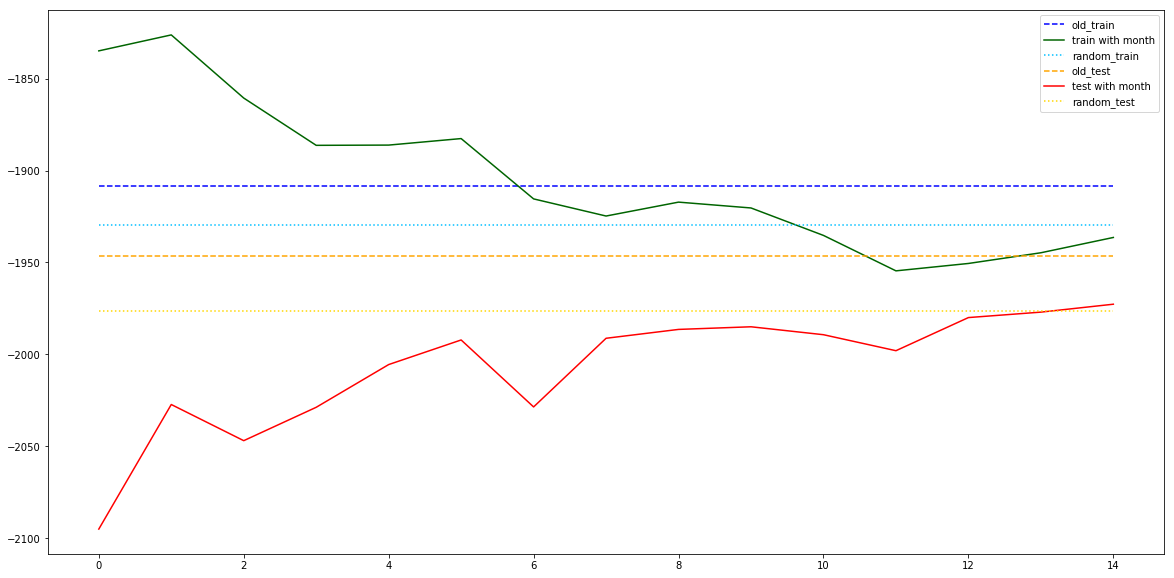

In [170]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 10))
plt.plot(train_ll_old, c ='blue', label ='old_train', linestyle ='--')
plt.plot(train_ll[::-1], c='darkgreen', label ='train with month')
plt.plot(train_ll_random, c ='deepskyblue', label ='random_train', linestyle =':')
plt.plot(test_llold, c='orange', label ='old_test', linestyle ='--')
plt.plot(test_ll[::-1], c ='red', label ='test with month')
plt.plot(test_ll_random, c ='gold', label ='random_test', linestyle =':')
plt.legend(loc ='upper right')
plt.show()

#### to the mean of time slice

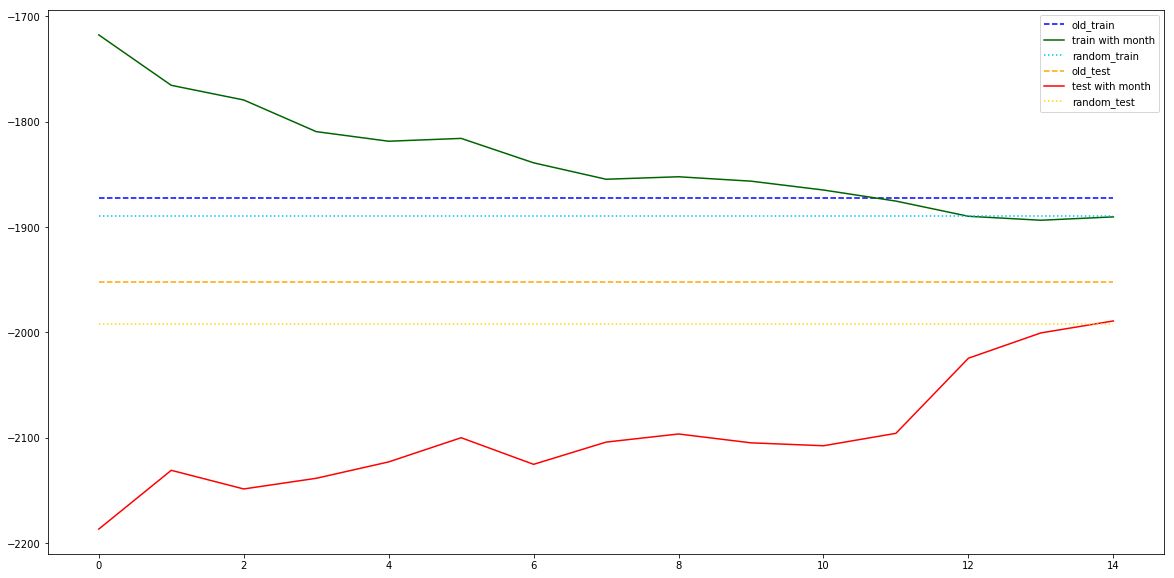

In [169]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 10))
plt.plot(train_ll_old_mean, c ='blue', label ='old_train', linestyle ='--')
plt.plot(train_ll_mean[::-1], c='darkgreen', label ='train with month')
plt.plot(train_ll_random_mean, c ='deepskyblue', label ='random_train', linestyle =':')
plt.plot(test_ll_old_mean, c='orange', label ='old_test', linestyle ='--')
plt.plot(test_ll_mean[::-1], c ='red', label ='test with month')
plt.plot(test_ll_random_mean, c ='gold', label ='random_test', linestyle =':')
plt.legend(loc ='upper right')
plt.show()

In [139]:
from thbmodel.prediction.tools.clustering import write_dic_to_simdata

#write_dic_to_simdata('new_factors_direction_new_code.p', new_model.step1probs, new_model.eff_coefs, oos, av =av)
write_dic_to_simdata('old_model_15m.p', tsmod.step1probs, tsmod.eff_coefs, pars.oos, av=av)

In [144]:
from thbmodel.prediction.tools.clustering import write_dic_to_simdata

#write_dic_to_simdata('new_factors_direction_new_code.p', new_model.step1probs, new_model.eff_coefs, oos, av =av)
write_dic_to_simdata('model_15m_back.p', time_model[0].step1probs, time_model[0].eff_coefs, pars.oos, av=av)

In [145]:
from thbmodel.prediction.tools.clustering import write_dic_to_simdata

#write_dic_to_simdata('new_factors_direction_new_code.p', new_model.step1probs, new_model.eff_coefs, oos, av =av)
write_dic_to_simdata('model_0m_back.p', time_model[14].step1probs, time_model[14].eff_coefs, pars.oos, av=av)

In [174]:
time_model[14].step1probs.shape, time_model[14].eff_coefs.shape

((11, 1805375), (11, 3))

In [183]:
 pars.is1, pars.is2, pars.oos =  is1, is2, oos

### relation from size of train set

In [184]:
random_model = {}

train_events = np.unique(av.event_id[pars.is1])

x = np.linspace(1./N_model, 1, num=12)
train_ll_random = np.zeros_like(x)
test_ll_random = np.zeros_like(x)
train_ll_random_mean = np.zeros_like(x)
test_ll_random_mean = np.zeros_like(x)

for i,s in enumerate(x): 
    
    random_train_events = np.random.choice(train_events, size = int(s * len(train_events)))

    random_model[i] = TSModel(factors, tsav, pars)
    random_model[i].params.is1 = is1 & np.in1d(av.event_id, random_train_events)
    
    random_model[i].fit_slices()
    
    print 
    print 'LL.....model {}.........'.format(i+1)
    print random_model[i].stats2.ll
    
    train_ll_random[i] = random_model[i].stats2.ll[-2,0]
    test_ll_random[i] = random_model[i].stats2.ll[-2,2]
    train_ll_random_mean[i] = np.nanmean(random_model[i].stats2.ll, axis =0)[0]
    test_ll_random_mean[i] = np.nanmean(random_model[i].stats2.ll, axis =0)[2]


LL.....model 1.........
[[-1854.06226922 -2006.22297226 -2006.22297226]
 [-1858.32290719 -2006.00212944 -2006.00212944]
 [-1862.26751371 -2006.34708548 -2006.34708548]
 [-1863.94894909 -2002.17493448 -2002.17493448]
 [-1873.22934587 -1988.09404025 -1988.09404025]
 [-1883.64278668 -1987.72266472 -1987.72266472]
 [-1909.30001818 -1980.78097657 -1980.78097657]
 [-1919.31205912 -1975.19501802 -1975.19501802]
 [-1922.97599395 -1978.13997199 -1978.13997199]
 [-1924.54864234 -1971.771462   -1971.771462  ]
 [           nan            nan            nan]]

LL.....model 2.........
[[-1846.94962177 -1974.36185592 -1974.36185592]
 [-1851.05574872 -1973.72002475 -1973.72002475]
 [-1854.31865395 -1972.32257067 -1972.32257067]
 [-1856.24523506 -1970.3287515  -1970.3287515 ]
 [-1866.61571431 -1962.15814323 -1962.15814323]
 [-1876.53338565 -1961.8794802  -1961.8794802 ]
 [-1901.46147246 -1959.09407716 -1959.09407716]
 [-1910.47236691 -1955.27658799 -1955.27658799]
 [-1912.96051613 -1956.46810937 -1956

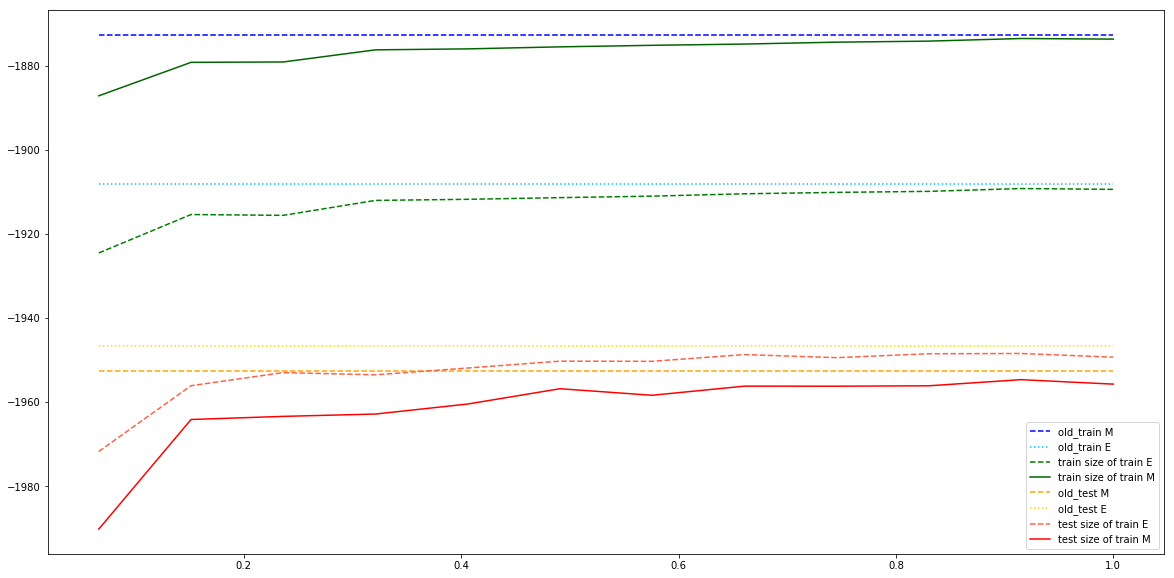

In [192]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 10))
plt.plot(x, train_ll_old_mean[:12],c ='blue', label ='old_train M', linestyle ='--')
plt.plot(x, train_ll_old[:12], c ='deepskyblue', label ='old_train E', linestyle =':')
plt.plot(x, train_ll_random[:12], c='green', label ='train size of train E', linestyle ='--')
plt.plot(x, train_ll_random_mean[:12], c='darkgreen', label ='train size of train M')


plt.plot(x, test_ll_old_mean[:12], c='orange', label ='old_test M', linestyle ='--')
plt.plot(x, test_llold[:12], c ='gold', label ='old_test E', linestyle =':')
plt.plot(x, test_ll_random[:12], c ='tomato', label ='test size of train E', linestyle ='--')
plt.plot(x, test_ll_random_mean[:12], c ='red', label ='test size of train M')

plt.legend(loc ='lower right')
plt.show()